In [2]:
import pandas as pd
df = pd.read_csv('c:/data/time/pollution.csv', index_col=0)
df

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


<AxesSubplot:>

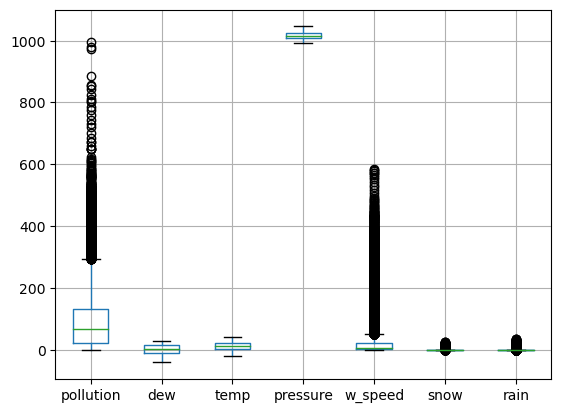

In [3]:
df.boxplot()

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
values = df.values
encoder = LabelEncoder()
# w_dr 변수 정수인코딩
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
np.unique(values[:,4])

array([0., 1., 2., 3.], dtype=float32)

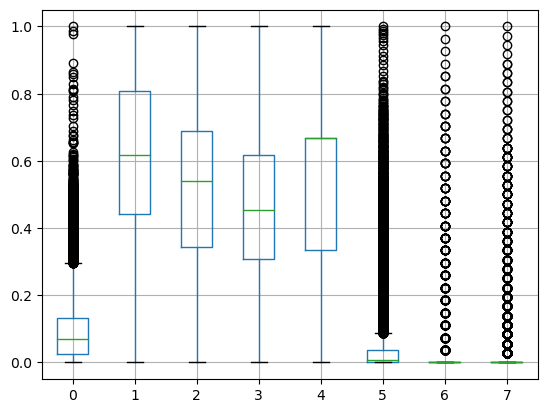

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).boxplot()
plt.show()

In [6]:
#쉬프트
def shift(train):
    timestep = 4
    X = []
    y = []
    for i in range(timestep, len(train)):
        X.append(train[i-timestep:i,:]) # pollution ~ rain
        y.append(train[i,0:1]) # pollution
    return X,y

In [7]:
X, y = shift(scaled)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(43796, 4, 8)
(43796, 1)


In [17]:
X[0] # 1~4시간 전

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ]], dtype=float32)

In [18]:
y[0]

array([0.13883299], dtype=float32)

In [8]:
#학습용:검증용 8:2 (4년:1년)
n_train= int(len(X)*.2)+1
X_train, X_test = X[n_train:,] , X[:n_train,]
print(X_train.shape, X_test.shape)
y_train, y_test = y[n_train:,] , y[:n_train,]
print(y_train.shape)
print(y_test.shape)

(35036, 4, 8) (8760, 4, 8)
(35036, 1)
(8760, 1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()
#return_sequences = False 기본값, 마지막 스텝만 내보내는 옵션
#return_sequences = True, 모든 스텝에 내보내는 옵션(LSTM을 여러층으로 만들 경우 사용)
model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
#             출력노드수   LSTM을 여러층으로 쌓기 위한 설정
#                         default=False: 마지막 스텝만 보내기
model.add(Dropout(0.2)) #출력신호 20% 오프(과적합 방지)
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1)) #출력노드 1개, linear
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             11800     
                                                                 
 dropout (Dropout)           (None, 4, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [10]:
model.fit(X_train, y_train, validation_split=0.2, epochs = 10, batch_size = 32)

Epoch 1/10
876/876 [==============================] - 15s 10ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/10
876/876 [==============================] - 8s 9ms/step - loss: 0.0013 - val_loss: 6.6043e-04
Epoch 3/10
876/876 [==============================] - 7s 8ms/step - loss: 0.0010 - val_loss: 5.3009e-04
Epoch 4/10
876/876 [==============================] - 7s 8ms/step - loss: 9.3952e-04 - val_loss: 5.5147e-04
Epoch 5/10
876/876 [==============================] - 7s 8ms/step - loss: 9.1012e-04 - val_loss: 5.5741e-04
Epoch 6/10
876/876 [==============================] - 7s 8ms/step - loss: 9.0124e-04 - val_loss: 5.1515e-04
Epoch 7/10
876/876 [==============================] - 7s 8ms/step - loss: 9.0966e-04 - val_loss: 6.1891e-04
Epoch 8/10
876/876 [==============================] - 7s 8ms/step - loss: 8.9286e-04 - val_loss: 5.4326e-04
Epoch 9/10
876/876 [==============================] - 7s 8ms/step - loss: 8.6513e-04 - val_loss: 5.0524e-04
Epoch 10/10
876/876 [=====================

In [11]:
from sklearn.metrics import mean_squared_error
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
rmse

274/274 [==============================] - 2s 3ms/step


0.030696368

In [12]:
d = scaled[:n_train,:]
y_predicted = np.concatenate((pred,d[:n_train,1:]), axis =1)
y_tested = np.concatenate((y_test, d[:n_train,1:]), axis = 1)

In [13]:
#스케일링 하기 전으로 복구
y_predicted = scaler.inverse_transform(y_predicted)
y_tested = scaler.inverse_transform(y_tested)
y_predicted = y_predicted[:,0:1]
y_tested = y_tested[:,0:1]

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_tested, y_predicted)
rmse = np.sqrt(mse)
rmse

30.512192

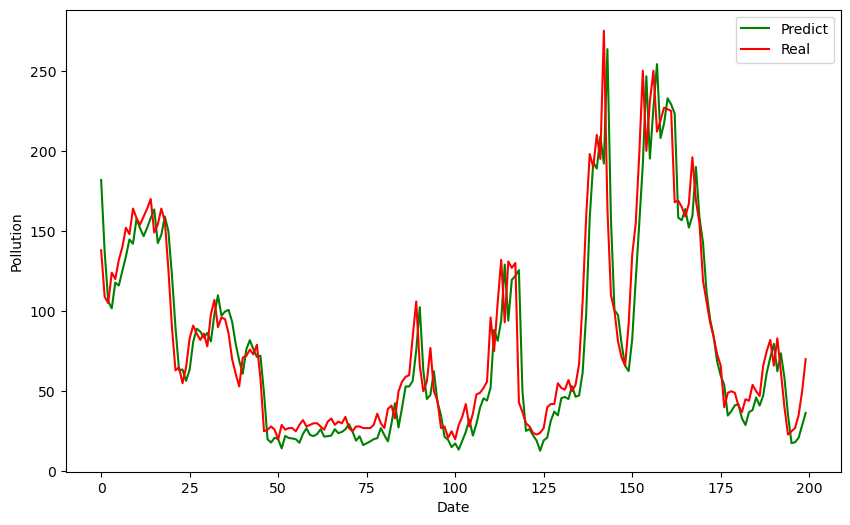

In [20]:
plt.figure(figsize=(10,6))
plt.plot(y_predicted[:200,:], color= 'g',label = 'Predict')
plt.plot(y_tested[:200,:] , color = 'r',label = 'Real')
plt.xlabel("Date")
plt.ylabel("Pollution")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_tested, y_predicted)
print('RMSE' , np.sqrt(mse))

RMSE 30.512192
